In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

env = SimpleControlledFixedEnv()

2024-04-19 09:37:00.278470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 09:37:00.469769: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


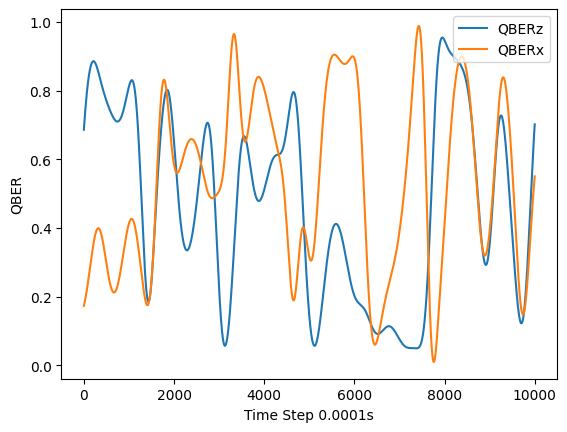

In [4]:
env.max_t = 1
env.reset()

while not env.done:
    env.step()

QBER = env.get_qber()

In [4]:
QBER = np.load('data/QBER.npy')

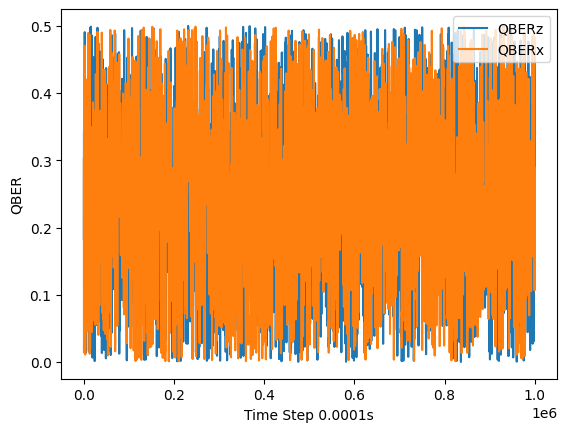

In [3]:
plt.plot(QBER[:,0],label='QBERz')
plt.plot(QBER[:,1],label='QBERx')
plt.legend(loc = 'upper right')
plt.ylabel('QBER')
plt.xlabel(f'Time Step {env.delta_t}s')
plt.show()

In [4]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

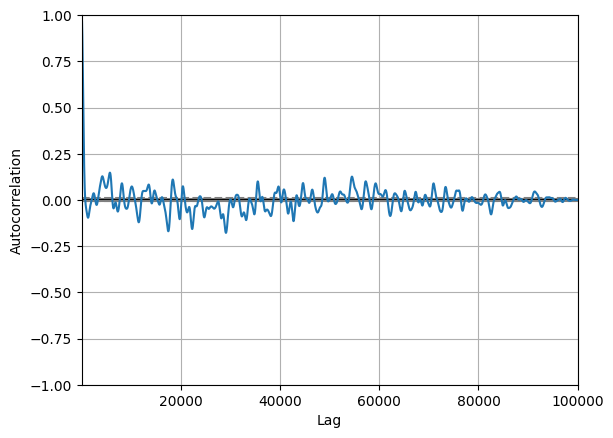

In [5]:
autocorrelation_plot(QBER[:100000,0])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

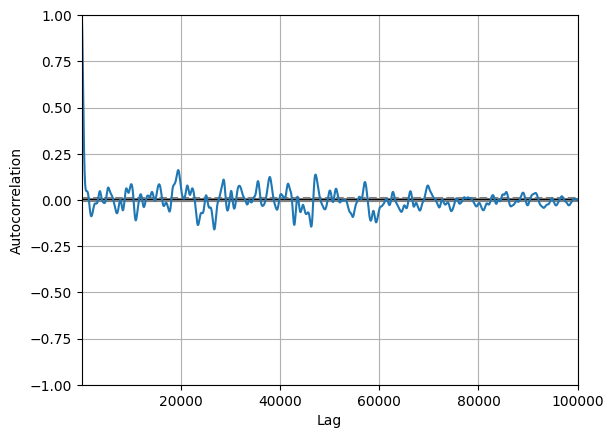

In [6]:
autocorrelation_plot(QBER[:100000,1])

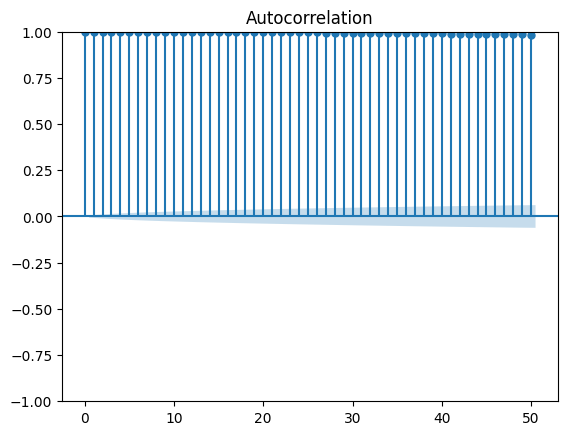

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(QBER[:100000,0])
plt.show()

In [14]:
qberz = QBER[:100000,0]

In [12]:
# import pmdarima as pmd

# model=pmd.auto_arima(QBER[:100000,0],start_p=1,start_q=1,test='adf',seasonal=True,trace=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2115907.074, Time=56.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1266180.609, Time=11.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=56.17 sec


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1266178.609, Time=17.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1266182.589, Time=2.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=43.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2129324.417, Time=43.68 sec


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1266176.608, Time=21.66 sec


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2118733.178, Time=30.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1266147.424, Time=72.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1266149.183, Time=67.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1266145.664, Time=93.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 519.542 seconds


/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "/usr/local/lib/python3.8/dist

In [15]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(qberz, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)
# p-value <= significance level (0.01, 0.05, 0.10, etc.)
# If the p-value is greater than the significance level then
# we can say that it is likely that the data is not stationary.

Results of Dickey Fuller Test:
Test Statistic                    -0.690954
p-value                            0.849079
#Lags Used                         4.000000
Number of Observations Used    99995.000000
Critical Value (1%)               -3.430415
Critical Value (5%)               -2.861569
Critical Value (10%)              -2.566785
dtype: float64


In [6]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# sarima = SARIMAX(QBER[100000:200000,0],order=(1,1,1),seasonal_order=(1,0,1,12))
# predicted = sarima.fit().predict()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15411D+02    |proj g|=  3.26304D+09


 This problem is unconstrained.



At iterate    5    f= -1.07687D+01    |proj g|=  1.01656D+05
  ys=-1.789E-04  -gs= 4.123E-04 BFGS update SKIPPED
  ys=-1.421E-17  -gs= 1.932E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     71      2     2     0   1.017D+05  -1.077D+01
  F =  -10.768710498620500     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


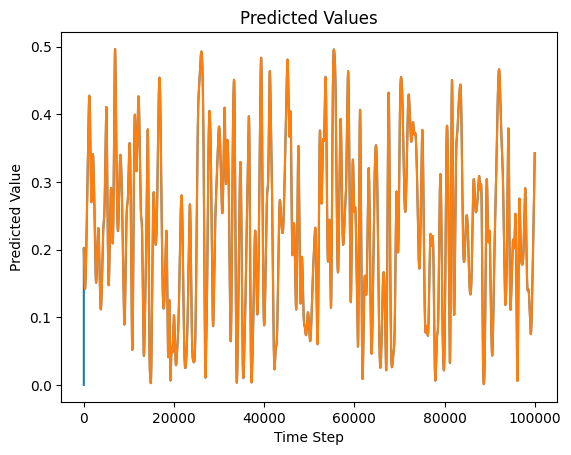

In [9]:
# plt.plot(predicted)
# plt.plot(QBER[100000:200000,0])
# plt.xlabel('Time Step')
# plt.ylabel('Predicted Value')
# plt.title('Predicted Values')
# plt.show()
